In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import keras
import numpy as np  # For numerical operations and generating noise
import tensorflow as tf  # For building and training the model
from tensorflow.keras.datasets import mnist  # To load the MNIST dataset
from tensorflow.keras.models import Model  # For defining the model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate  # Layers used in the model

2024-08-16 06:48:15.070303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 06:48:15.070403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 06:48:15.217212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_train = x_train.reshape(len(x_train),28,28,1)
x_test = x_test.reshape(len(x_test),28,28,1)

In [8]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [9]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

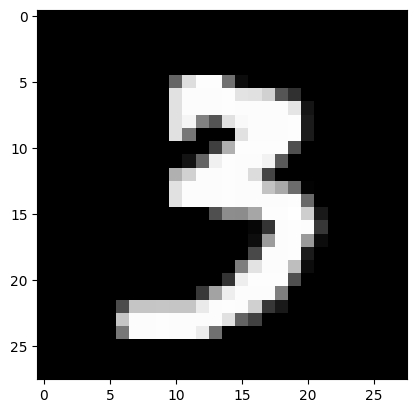

In [12]:
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test[index].reshape(28,28))
plt.gray()

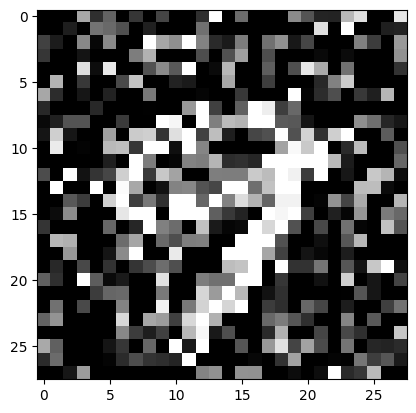

In [13]:
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test_noisy[index].reshape(28,28))
plt.gray()

## UNET ARCHITECTURE
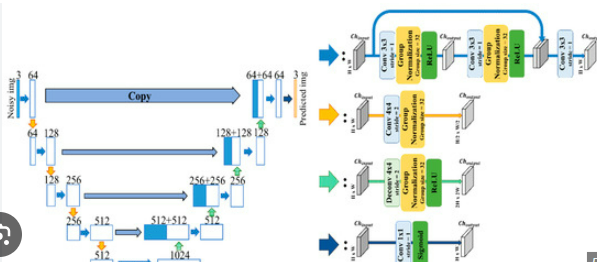
Encoder (Contracting Path): The left side of the U-Net performs downsampling. It captures the context by progressively reducing the image size using convolutional layers followed by max-pooling. Each downsampling step doubles the number of feature channels.

Decoder (Expanding Path): The right side of the U-Net performs upsampling. It restores the image to its original size using transposed convolutions. Each step halves the number of feature channels while spatially increasing the resolution.

The bottleneck area in U-Net captures the most essential features of the input image after downsampling and acts as the core transition point before the upsampling process in the decoder path begins.

Skip Connections: U-Net introduces skip connections between the corresponding layers of the encoder and decoder paths. These connections transfer high-resolution features from the encoder to the decoder, helping to recover fine-grained details lost during downsampling.

In [14]:
import tensorflow as tf

def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Max Pooling with 2x2 filter
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    # Upsampling using Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(num_filters, 
                                        (3, 3),  
                                        strides=(2, 2))(inputs)

    # Concatenate the upsampled input with the skip connection
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def decoder_block2(inputs, skip_features, num_filters):
    # Upsampling using Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(num_filters, 
                                        (2, 2),  
                                        strides=(2, 2))(inputs)

    # Concatenate the upsampled input with the skip connection
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def unet_model(input_shape=(28, 28, 1)):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(256, 3, padding='same')(p3)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(256, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Expansive Path
    d3 = decoder_block(b1, s3, 128)
    d2 = decoder_block2(d3, s2, 64)
    d1 = decoder_block2(d2, s1, 32)

    # Output layer for grayscale image reconstruction
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d1)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')

    return model

if __name__ == '__main__':
    model = unet_model(input_shape=(28, 28, 1))
    model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 7, 7, 128) │          0 │ conv2d_4[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 7, 7, 128) │          0 │ conv2d_5[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 128) │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 3, 3, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 3, 3, 256) │          0 │ conv2d_6[0][0]  

 Total params: 2,088,865 (7.97 MB)

 Trainable params: 2,088,865 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train_noisy,  # Noisy images
    x_train,        # Clean images (target)
    validation_data=(x_test_noisy, x_test),  # Validation data
    batch_size=64,
    epochs=10
)

Epoch 1/10
  7/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.4793 - loss: 0.6841

I0000 00:00:1723791018.637642     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8042 - loss: 0.1748 - val_accuracy: 0.8123 - val_loss: 0.0928
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8146 - loss: 0.0914 - val_accuracy: 0.8130 - val_loss: 0.0884
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8143 - loss: 0.0885 - val_accuracy: 0.8134 - val_loss: 0.0871
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8138 - loss: 0.0872 - val_accuracy: 0.8132 - val_loss: 0.0865
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8143 - loss: 0.0861 - val_accuracy: 0.8135 - val_loss: 0.0859
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8140 - loss: 0.0855 - val_accuracy: 0.8135 - val_loss: 0.0860
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8144 - loss: 0.0848 - val_accuracy: 0.8134 - val_loss: 0.0857
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8144 - loss: 0.0844 - val_accurac

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate , BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer, start_neurons):
    # Encoder
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation('relu')(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), padding='same')(pool4)
    convm = BatchNormalization()(convm)
    convm = tf.keras.layers.Activation('relu')(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), padding='same')(convm)
    convm = BatchNormalization()(convm)
    convm = tf.keras.layers.Activation('relu')(convm)

    # Decoder
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2))(convm)
    uconv4 = concatenate([deconv4, conv4], axis=-1)
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding='same')(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.Activation('relu')(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding='same')(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.Activation('relu')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2))(uconv4)
    uconv3 = concatenate([deconv3, conv3], axis=-1)
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding='same')(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding='same')(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (2, 2), strides=(2, 2))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=-1)
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding='same')(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding='same')(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (2, 2), strides=(2, 2))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=-1)
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding='same')(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding='same')(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.Activation('relu')(uconv1)

    # Output layer for denoising MNIST images
    output_layer = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(uconv1)

    return output_layer

# Define model
img_size_target = 28
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 32)
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='binary_crossentropy')  # Binary crossentropy for denoising
model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_14[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 14, 14,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 14, 14,    │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 7, 7, 64)  │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 64)  │          0 │ max_pooling2d_4[

 Total params: 8,590,497 (32.77 MB)

 Trainable params: 8,584,609 (32.75 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [17]:
model_unet.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

history = model_unet.fit(
    x_train_noisy,  # Noisy images
    x_train,        # Clean images (target)
    validation_data=(x_test_noisy, x_test),  # Validation data
    batch_size=64,
    epochs=10
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 86s 56ms/step - accuracy: 0.7906 - loss: 0.0430 - val_accuracy: 0.8131 - val_loss: 0.0100
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8141 - loss: 0.0102 - val_accuracy: 0.8133 - val_loss: 0.0089
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8141 - loss: 0.0094 - val_accuracy: 0.8135 - val_loss: 0.0086
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.8145 - loss: 0.0090 - val_accuracy: 0.8131 - val_loss: 0.0083
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8138 - loss: 0.0088 - val_accuracy: 0.8134 - val_loss: 0.0080
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8145 - loss: 0.0086 - val_accuracy: 0.8136 - val_loss: 0.0082
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8145 - loss: 0.0084 - val_accuracy: 0.8129 - val_loss: 0.0083
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8143 - loss: 0.0084 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


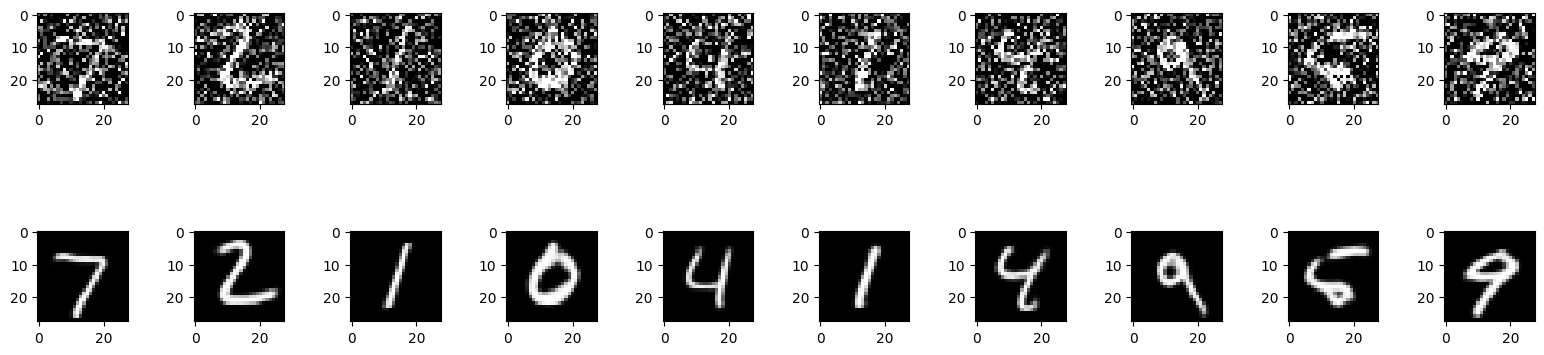

In [18]:
no_noise_img = model_unet.predict(x_test_noisy)
plt.figure(figsize=(40, 4))
for i in range(10) :
  ax = plt.subplot(3, 20, i + 1)
  plt.imshow(x_test_noisy[i].reshape(28, 28), cmap = 'gray')

  ax = plt.subplot(3, 20, 40+i+1)
  plt.imshow(no_noise_img[i].reshape(28, 28), cmap = 'gray')

plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(x_test.reshape(-1), no_noise_img.reshape(-1))
mse = mean_squared_error(x_test.reshape(-1), no_noise_img.reshape(-1))

print("MAE:", mae)
print("MSE:", mse)

Accuracy = (1 - (mse / (255**2))) * 100
print(Accuracy)

MAE: 0.029132858
MSE: 0.007953182
99.9999877690398


In [20]:
from sklearn.metrics import accuracy_score
import numpy as np

# Make predictions on the noisy test data
y_pred = model_unet.predict(x_test_noisy)

# Threshold the predicted values to binary (0 or 1), assuming a threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Threshold the true values to binary as well
x_test_binary = (x_test > 0.5).astype(np.uint8)

# Flatten both the predicted and true binary values
y_pred_flat = y_pred_binary.flatten()
x_test_flat = x_test_binary.flatten()

# Calculate accuracy
accuracy = accuracy_score(x_test_flat, y_pred_flat)

print(f"Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 97.46%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


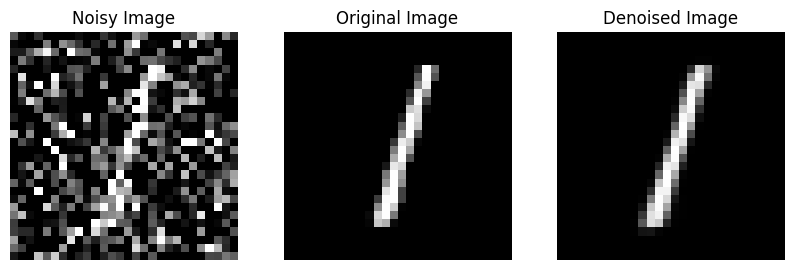

In [21]:
import matplotlib.pyplot as plt

# Pick an example from the test set
index = 2 # You can choose any index
noisy_image = x_test_noisy[index].reshape(28, 28)
original_image = x_test[index].reshape(28, 28)

# Predict the denoised image
denoised_image = model_unet.predict(x_test_noisy[index:index+1])
denoised_image = denoised_image.reshape(28, 28)

# Plot the noisy and denoised image side by side
plt.figure(figsize=(10, 4))

# Plot noisy image
plt.subplot(1, 3, 1)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

# Plot original image
plt.subplot(1, 3, 2)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Plot denoised image
plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.show()